# Deep Convolutionnal Generative Adversarial Network (DCGAN)
# DL Lecture with Pr. Kelly Joly

### Aymeric MILLAN & Arthur VIENS

In this notebook we are going to present our DCGAN. Its purpose is to generate
fake images that look like real images, after training on a particular dataset. 
We were interested in GANs because we thought it would be really interesting to 
dive into the details of training one. For other types of deep learning 
architectures, it can be pretty straightforward to train a network, but that is 
not the case with GANs.

Here is an example of three generated pictures of resolution `128x128`. This
training has been done with a [landscapes dataset](google.com). The rendering is
not perfect at all, and couldn't fool a human discriminator, but we can see that
it is starting to _look like_ a landscape. 

![Example of generated images](fig/sluggy_landscapes.png)

Our training was executed on NVIDIA's last generation GPUs, `A100`. Even with
such computational power, training our network took quite a long time. To be
able to _start_ to see some result, and taking decision on adjusting our
network, we nedded at least 10-12 hours. And this is for `128x128` images.
We will discuss about scaling up our GAN later.  

This report is organized as following. Section I discusses the datasets and data loaders before section II explains our architecture. We talk about our training strategies in section III, the problems we encountered in section IV, what could be improved in section V and a demonstration on section VI.

# I - Data Loaders and Datasets

The first part of the project was to be able to load correctly our datasets. For
this, we used the different utility classes of PyTorch such as `Dataset` and
`DataLoader` from `torch.utils.data`. With these classes, we just have to
implement some methods to retrieve an item from the dataset and to get the total
length of the dataset, and we can use the whole system behind it.
For example, it is possible to use this machinery to do shuffling, multiprocess
loading, batch prefetching, dataset weighting and much more.

Moreover, we used different image transforms from `torchvision.transform`, such
as resizing, cropping, horizontal flipping or transforms composition for
example. It was really useful to use this kind of transformations for data
augmentation. Hence, the images from dataset are not always exactly the same and
it makes it harder for the network to overfit on the training set.

Here is an example of how we can generate multiple pictures with a simple crop
or flip :

<!-- ![Example of data augmentation](fig/data_aug.png) -->
<img src="fig/data_augm.png" alt="Example of data augmentation" width="910"/>

As the landscapes dataset's size is more than 10 GB, it can not fit in memory at 
once. Hence, it is usefull to load images on the fly and compute the 
transformations at the same time. To achieve this, we tuned the
`prefetch factor` and the number of workers to use the full capacity of the
available GPUs.

In our actual code, the pipeline of data loading is :

1. Selection of a random image
2. Read image as 3d matrix
3. Resize image
4. Crop image to the size we want to generate
5. Transform to a PyTorch tensor
6. 50% chance of horizontal flip the image



# II - Architecture

At first, we began by modeling an autoencoder, because downsampling images 
and upsampling them is not very easy when you are a beginner, and the results
of autoencoders are immediately visible. When our building blocks were ready,
we began the construction of our GAN architecture based on the AE's architecture.

We started off very simple. Our first network was a fully 
connected GAN creating `28x28` images of black and white numbers, as we trained 
first on MNIST dataset. We increased the complexity afterwards, replacing 
fully-connected linear layers with convolutional layers, transposed 
convolutions and upsampling layers. It is pretty simple for a GAN to generate 
small images such as MNIST digits. But as the resolution increases, it becomes
harder and harder to have satisfactory results. The scaling up of a GAN is not
a trivial task.

Our last architecture is composed of many _ResBlocks_ and _ResUpBlocks_, in order 
to keep the gradient flowing through the layers via the skip connections. 
Our networks are quite deep, and it is important for the gradient to flow, 
else the training fails or takes an extremely long time. Our ResBlock is built 
as such : 

![Resblock example](fig/resblock.png)

Our ResBlock uses **convolutional layers** to scale down the image, and our
ResUpBlock use **upsampling** and **convolutional layers** to scale up the image.

If the layer is supposed to scale up or down the image size, or to change the
number of channels, the identity is replaced with a convolutional or an
upsampling layer to be able to add the different paths of the forward pass.

We saw on the litterature different ways to implement the ResBlock, but we 
chose one that we thought was best for us, and eventually, we engineered it even
more to best fit our needs.

Our whole architeture depends on the size of the images we want to generate.
Of course, a network will need more parameters to generate `256x256` images than
`128x128` images, so the architecture is similar, but we add additional layers
for `256x256` generation.

Our final model has 26 730 567 parameters for the Generator and 16 901 081 parameters for the
discriminator, you can check the architecture in the `gan_architecture.py` file.

Additionnaly, we tried to add building blocks from the SAGAN architecture
[(Zhang et al)](https://arxiv.org/abs/1805.08318), namely the self-attention
layer aswell as the spectral normalization, but it did not improve our generations.


# III - Training strategies

Training a GAN is not straightforwards. This process is a zero-sum game between 
the generator and the discriminator. Because of this, they are able to train 
each other as they take turn in winning the game. It needs a complicated 
equilibrium in order to succesfully generate images that feel real for human 
eye. If one of them is too strong for the other, it generally makes the other 
one collapse, and training fails. It is of paramount importance to train them 
in such a way that they are approximately at the same level. <br/>

GANs are trained in the following fashion : In each training loops, we sample
first a batch of points from the latent space, that we feed to the generator
that outputs a batch of fake images. We feed them to the discriminator, that
has to label them as real or fake. Obviously, its goal is to label the
generator images as fake. We then feed a batch of images from the dataset to
the discriminator, that has to label them aswell. Once the training step of the
discriminator is finished, we train the generator. After sampling a batch of
latent points and feeding them to the generator, we freeze the discriminator
weights and ask it to label the fake images. Here, the goal of the generator is
to have its images labeled as real, and we compute the loss accordingly.

The following [diagram](https://developers.google.com/machine-learning/gan/discriminator) 
summarize this process : 

<img src="fig/google_diagram.svg" alt="Training of a GAN" width="700"/>

There are different variants of how we execute this training, and different ways
to tweak the training. For example we can :
- Train k times the discriminator and only once the generator (k is typically 
low : 2 or 3)
- Use a different learning rate for each network
- Add noise the to real and generated images
- Change the latent space dimension (not trivial, the whole network
architecture needs to be able to convert it to an image)
- Perform "label smooting", by setting the label of real images to 0.9 instead
of 1 for example, in order regularize the discriminator by making it less 
overconfident of his predictions
- Tune the different hyperparameters
- Regularize the networks with L1, L2 weight decay

# IV - Problems we encountered

We faced many various difficulties while implementing this GAN, which we are
going to present in this section. The problems we encoutered mainly came from
two sides :
- Architecture : These were all the "inner" problems, which are directly related
to the network (e.g., which convolutionnal layers to use, how to avoid gradient
vanishing, what size of upsampling, etc.)
- Training : These are the "outer" problems, which are not directly related to
the architecture of our GAN, but mostly about the training. For example, setting
the right learning rate, or choosing the frequency of training of the generator
regarding the discriminator, etc.

It was hard to understand which architecture was the right one at first. As for
many Deep Learning tasks, the questions we ask ourselves are: Which layers?
What sizes of layer? Which activation? Which loss? What's the training scheme?
Eventually we found lots of information about these questions and understood
what could be best for GANs.

**Checkerboard artifacts** was the first problem we ran into. It makes grids 
on the generated images like in the following :

![Checkerboard illustration](fig/checkerboard.png)

It is a byproduct of the inner workings of transposed convolutions, that make
certain pixels values very high or very low, and compounds these effects at
each transposed conv layer.

To alleviate this effect, we used upsampling + convolutional layers instead of
transposed convolutional layers for the generator architecture. This removed
immediately all the artifacts.

**Scaling up** GANs does not work like we would like it to do. It is not as 
simple as adding more layers to the network and hoping for the best. We found
that we had to change the whole architecture to generate bigger images. New training
techniques and architecture have to be used, because many problems arise from
the size of the network and of the images we want to generate.

The **training losses** are also something we struggled with. In all our 
experiments, they did not look like what we could see on internet or in the 
litterature, and we failed to understand why. Especially for the discriminator,
our losses are often flat, with peaks when the generator is good at fooling the
discriminator. But it seems that the discriminator is always good at 
recognizing training set pictures.

<img src="fig/loss.png" alt="Loss and accuracy" width="750"/>

**Mode collapse** is perhaps the most annoying training issue that happened the 
most in this project. The generator started to generate extremely bad quality
images, and always the same type of images. Each entry noise of the network
resulted in the same output image. It is a known issue of GAN training, that
is hard to avoid.

Here is a GIF showing a training that collapsed at first, and then managed to
decollapse. We stopped that training because we were using a bilinear mode for
the upsampling of the image in our ResBlocks instead of using the nearest
neighbors mode, which gives better results. You can see the decollapsing around
epoch 20.

![Training managing to decollapse](fig/sluggif_collapse.gif)

# V - What we think could be improved

Obviously, we did not achieve what we wanted to achieve in the first place with
our GAN : generating real-like landscapes. GANs for medium to big images (128
and more) is extremely hard to train, and few architectures succeed in doing so.

We did not want to copy an architecture from open-source code, as it would not
have been pedagogically interesting. We preferred the process of finding
building blocks, tips and ideas from different papers and repositories to get a
decent GAN. However, this is a very hard process, because it involves reading
papers and understanding state of the art Deep Learning Research from the few
past years.

We have a few grey areas, questions that we did not find answers online, that remain.
- How does the size of the latent space really impact the generation ?
- Do we need the generator and discriminator to have the same number of learnable parameters ? Do they need to be strictly "symmetric" ?
- Why does our GAN rapidly creates images that seem like landscapes from afar, and then adds too much details at the point where it does not seem real at all ?

There is a vast litterature about GANs, but we could not find time to read all
of them for one project, but some of them could have the answer to why our GAN is not perfect.
We could read more about [(Zhang et al)](https://arxiv.org/abs/1805.08318) SAGAN
paper, to understand more deeply this layer and what it really does to the training.
Our understanding is that is it supposed to give the network more information about
global features in order to have more realistic generation of complex objects.
It is "easy" for a network to learn to generate local features of a dog (an ear,
a paw...) but generating a realistic dog with all its parts at the right place
is something GANs have struggled to do historically.

This self-attention mechanism is also integrable via non-local blocks
[(Wang et al)](https://arxiv.org/abs/1711.07971) instead of self-attention
layers, and it seems to work in a similar way according to the litterature.


The integration of different loss like in Geometric GAN
[(Lim and Ye)](https://arxiv.org/abs/1705.02894v2), that have theoretical
arguments as for the convergence to Nash equilibrium for a GAN training. Or even
using the Wassertein distance as the loss [(Arjovsky et al)](https://arxiv.org/abs/1701.07875),
which has proven to be effective for stabilizing training.

Moreover, what seems to work best is using many of these state of the art
discovery, as is done on the BigGAN paper
[(Brock et al)](https://arxiv.org/abs/1809.11096). They use Spectral
Normalization to enforce Lipshitz continuity on the discriminator, class
information from conditional GANs, self-attention, orthonormal initialization,
big batch sizes, truncation trick... It works very well, because they achieved
better results than state of the art by orders of magnitude, when it came out in
2018.

# Demonstration of the Generator


In [4]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from dataload import *
from gan_architecture import *
from utils import *

In [86]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Set a small batch size for the demonstration
batch_size = 4

#Latent space is a vector of size z_dim
z_dim = 128

#Model for the notebook
file = "final-gan"

#We only load the generator to generate pictures here, no need for the discriminator
model = Generator(z_dim).to(device)
model.load_state_dict(torch.load(f"saved_models/{file}_generator.sav"))

<All keys matched successfully>

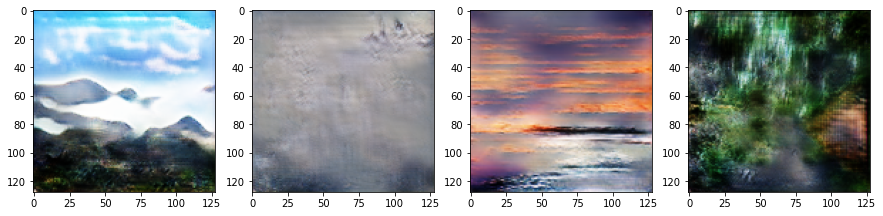

In [95]:
x = torch.randn(batch_size, z_dim)
i = np.random.randint(15)
x = x.to(device)
generated = model(x)

fig, axes = plt.subplots(1,4, figsize=(15,3.5))

for i in range(4):
    img = generated[i].detach().cpu().numpy().transpose((1, 2, 0))
    axes[i].imshow(img)

# Training on different datasets

This is the bonus section, here are a few GIFs showing different evolutions of
trainings.

We also tried to train our GAN on a dataset of berries, because we thought that
it might be simpler to learn for the model (it wasn't). 

<img src="fig/berries.png" alt="Berries dataset" width="550"/>

On the left you can see a training from the beginning using a **bilinear** mode
for the upsampling. On the right, we used the **nearest neighbors** mode :

![Bilinear berries](fig/sluggif_bilinear_berries.gif) ![Nearest berries](fig/sluggif_nearest_berries.gif)

Finally, the next GIF is our last model's training evolution. We can clearly see
that, even if the training on the berry dataset did not converge well, the colors
are not the same at all than for this last model, which we trained on the landscapes dataset.

![Final model](fig/sluggif_final_train.gif)